## Step 1: Import libraries

In [1]:
import xarray as xr 
import s3fs
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fs = s3fs.S3FileSystem(anon=True)

In [4]:
f = fs.open("s3://noaa-goes17/ABI-L2-MCMIPC/2021/050/18/OR_ABI-L2-MCMIPC-M6_G17_s20210501801176_e20210501803549_c20210501804089.nc")

In [5]:
ds = xr.open_dataset(f)

In [6]:
ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 2500, y: 1500)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1282 ... 0.04427
  * x                                       (x) float32 -0.06997 ... 0.06997
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-02-19T18:04:08.9Z
    time_coverage_start:       2021-02-19T18:01:17.6Z
    time_coverage_end:         2021-02-19T18:03:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        900b3680-135c-454d-a4ac-0940433763d6

In [7]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [8]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [9]:
ds = calc_latlon(ds)

In [10]:
ds.coords

Coordinates: (12/39)
    t                    datetime64[ns] 2021-02-19T18:02:36.315488
  * y                    (y) float32 0.1282 0.1282 0.1281 ... 0.04432 0.04427
  * x                    (x) float32 -0.06997 -0.06992 ... 0.06992 0.06997
    y_image              float32 0.08624
    x_image              float32 0.0
    band_wavelength_C01  (band) float32 0.47
    ...                   ...
    band_id_C13          (band) int8 13
    band_id_C14          (band) int8 14
    band_id_C15          (band) int8 15
    band_id_C16          (band) int8 16
    lat                  (y, x) float64 53.5 53.49 53.49 ... 14.8 14.8 14.81
    lon                  (y, x) float64 -184.4 -184.3 -184.2 ... -112.5 -112.4

In [11]:
lats = (30, 55)
lons = (-152, -112)

((x1,x2), (y1, y2)) = get_xy_from_latlon(ds, lats, lons)

In [12]:
subset = ds.sel(x=slice(x1,x2), y=slice(y2, y1))
subset

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 1808, y: 770)
Coordinates: (12/39)
    t                                       datetime64[ns] 2021-02-19T18:02:3...
  * y                                       (y) float32 0.1282 ... 0.08515
  * x                                       (x) float32 -0.03867 ... 0.06252
    y_image                                 float32 0.08624
    x_image                                 float32 0.0
    band_wavelength_C01                     (band) float32 0.47
    ...                                      ...
    band_id_C13                             (band) int8 13
    band_id_C14                             (band) int8 14
    band_id_C15                             (band) int8 15
    band_id_C16                             (band) int8 16
    lat                                     (y, x) float64 51.37 51.36 ... 30.01
    lon                                     (y, x) float64 -159.1 ... -112.0
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float64 260.5
    std_dev_brightness_temperature_C16      float64 14.5
    percent_uncorrectable_GRB_errors        float64 0.0
    percent_uncorrectable_L0_errors         float64 0.0
    dynamic_algorithm_input_data_container  int32 -2147483647
    algorithm_product_version_container     int32 -2147483647
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-02-19T18:04:08.9Z
    time_coverage_start:       2021-02-19T18:01:17.6Z
    time_coverage_end:         2021-02-19T18:03:54.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        900b3680-135c-454d-a4ac-0940433763d6

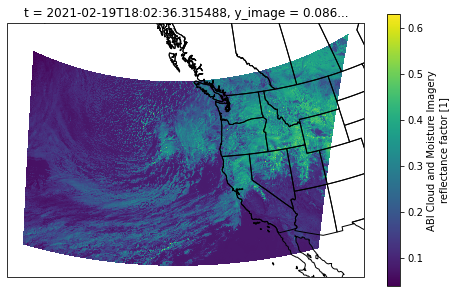

In [13]:
fig = plt.figure(figsize=(8,5))
p = subset.CMI_C01.plot(x='lon', y='lat', 
                   subplot_kws={
                       'projection' : ccrs.Orthographic(-130, 40),
#                        'extent' : (lons[0], lons[1], lats[0], lats[1])
                   }, transform=ccrs.PlateCarree())
# p.axes.set_global()
p.axes.add_feature(cfeature.COASTLINE)
p.axes.add_feature(cfeature.STATES)

In [14]:
r = subset['CMI_C02'].data; r = np.clip(r, 0, 1)
g = subset['CMI_C03'].data; g = np.clip(g, 0, 1)
b = subset['CMI_C01'].data; b = np.clip(b, 0, 1)

In [15]:
gamma = 2.5; r = np.power(r, 1/gamma); g = np.power(g, 1/gamma); b = np.power(b, 1/gamma)
g_true = 0.45 * r + 0.1 * g + 0.45 * b
g_true = np.clip(g_true, 0, 1)
rgb = np.dstack((r, g_true, b))

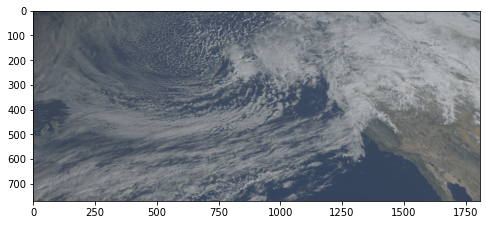

In [16]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)
ax.imshow(rgb)